<a href="https://colab.research.google.com/github/yasminghd/2022_ML_Earth_Env_Sci/blob/main/Lab_Notebooks/S1_5_Xarray.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

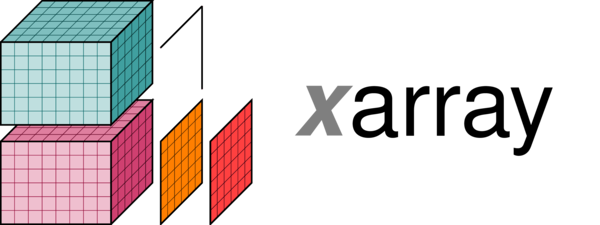

In the previous notebook, we saw how `Pandas` provided a way to keep track of additional “metadata” surrounding tabular datasets, including “indexes” for each row and labels for each column. These features, together with Pandas’ many useful routines for all kinds of data munging and analysis, have made Pandas one of the most popular python packages in the world.

However, not all Earth science datasets easily fit into the “tabular” model (i.e. rows and columns) imposed by `Pandas`. In particular, we often deal with *multidimensional* data. By *multidimensional* data (also often called N-dimensional), we mean data with many independent dimensions or axes. For example, we might represent Earth’s surface temperature $T$ as a three dimensional variable:

$T\left(x,y,t\right)$

where $x$ is longitude, $y$ is latitude, and $t$ is time.

The point of xarray is to provide `Pandas`-level convenience for working with this type of data.

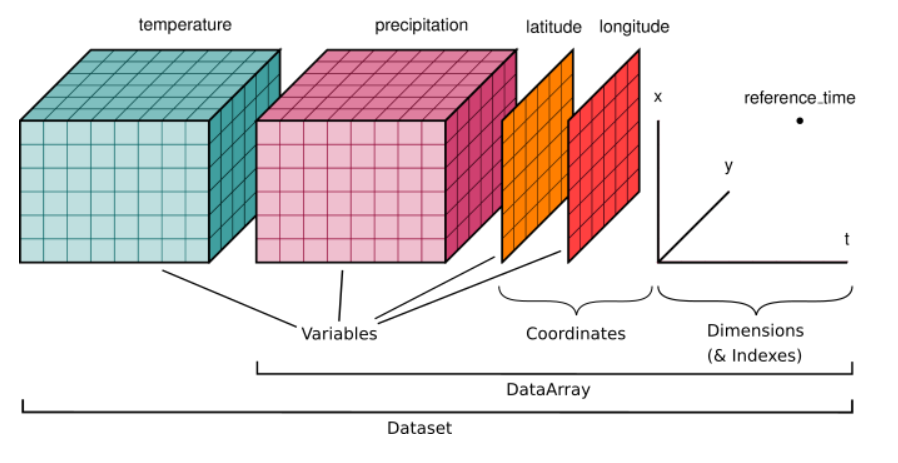

# Learning Goals for Xarray

**Dataset Creation**

1.    Describe the core `xarray` data structures, the `DataArray` and the `Dataset`, and the components that make them up, including: Data Variables, Dimensions, Coordinates, Indexes, and Attributes

2.    Create `xarray` `DataArrays` and `DataSets` out of raw `numpy` arrays

3.    Create `xarray` objects with and without indexes

4.    Load `xarray` datasets from `netCDF` files and `openDAP` servers

5.    View and set attributes

**Basic Indexing and Interpolation**

1.    Select data by position using `.isel` with values or slices

2.    Select data by label using `.sel` with values or slices

3.    Select timeseries data by date/time with values or slices

4.    Use nearest-neighbor lookups with `.sel`

5.    Mask data with `.where`

6.    Interpolate data in one and several dimensions

**Basic Computation**

1.    Do basic arithmetic with `DataArrays` and `Datasets`

2.    Use `numpy` universal function on `DataArrays` and `Datasets`, or use corresponding built-in `xarray` methods

3.    Combine multiple `xarray` objects in arithmetic operations and understand how they are broadcasted / aligned

4.    Perform aggregation (reduction) along one or multiple dimensions of a `DataArray` or `Dataset`

**Basic Plotting**

1.    Use built-in `xarray` plotting for 1D and 2D `DataArrays`

2.    Customize plots with options

# Xarray Data Structures

Like `Pandas`, `xarray` has two fundamental data structures:

*    A `DataArray`, which holds a single multi-dimensional variable and its coordinates

*    A `Dataset`, which holds multiple variables that potentially share the same coordinates

## DataArray

A `DataArray` has four essential attributes:

*    `values`: a `numpy.ndarray` holding the array’s values

*    `dims`: dimension names for each axis (e.g., ('x', 'y', 'z'))

*    `coords`: a dict-like container of arrays (coordinates) that label each point (e.g., 1-dimensional arrays of numbers, datetime objects or strings)

*    `attrs`: an OrderedDict to hold arbitrary metadata (attributes)

Let’s start by constructing some DataArrays manually

In [1]:
import numpy as np
import xarray as xr
from matplotlib import pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (8,5)

A simple DataArray without dimensions or coordinates isn’t much use.

In [2]:
da = xr.DataArray([9, 0, 2, 1, 0])
da

<xarray.DataArray (dim_0: 5)>
array([9, 0, 2, 1, 0])
Dimensions without coordinates: dim_0

We can add a dimension name:

In [3]:
da = xr.DataArray([9, 0, 2, 1, 0], dims=['x'])
da

<xarray.DataArray (x: 5)>
array([9, 0, 2, 1, 0])
Dimensions without coordinates: x

But things get most interesting when we add a coordinate:

In [4]:
da = xr.DataArray([9, 0, 2, 1, 0],
                  dims=['x'],
                  coords={'x': [10, 20, 30, 40, 50]})
da

<xarray.DataArray (x: 5)>
array([9, 0, 2, 1, 0])
Coordinates:
  * x        (x) int64 10 20 30 40 50

This coordinate has been used to create an *index*, which works very similar to a `Pandas` index. In fact, under the hood, `Xarray` just reuses `Pandas` `index`es.

In [5]:
da.indexes

x: Int64Index([10, 20, 30, 40, 50], dtype='int64', name='x')

`Xarray` has built-in plotting, like `Pandas`.

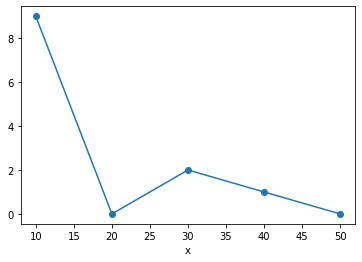

In [6]:
da.plot(marker='o')

## Multidimensional DataArray

If we are just dealing with 1D data, `Pandas` and `Xarray` have very similar capabilities. `Xarray`’s real potential comes with multidimensional data.

Let’s go back to the multidimensional ARGO data we loaded in the `numpy` lesson.

In [7]:
import pooch
url = "https://www.ldeo.columbia.edu/~rpa/float_data_4901412.zip"
files = pooch.retrieve(url, processor=pooch.Unzip(), 
                       known_hash="2a703c720302c682f1662181d329c9f22f9f10e1539dc2d6082160a469165009")
files

Unzipping contents of '/root/.cache/pooch/7e6685dbe2a3c0b0870f770f3ef413d9-float_data_4901412.zip' to '/root/.cache/pooch/7e6685dbe2a3c0b0870f770f3ef413d9-float_data_4901412.zip.unzip'


['/root/.cache/pooch/7e6685dbe2a3c0b0870f770f3ef413d9-float_data_4901412.zip.unzip/float_data/S.npy',
 '/root/.cache/pooch/7e6685dbe2a3c0b0870f770f3ef413d9-float_data_4901412.zip.unzip/float_data/lon.npy',
 '/root/.cache/pooch/7e6685dbe2a3c0b0870f770f3ef413d9-float_data_4901412.zip.unzip/float_data/date.npy',
 '/root/.cache/pooch/7e6685dbe2a3c0b0870f770f3ef413d9-float_data_4901412.zip.unzip/float_data/lat.npy',
 '/root/.cache/pooch/7e6685dbe2a3c0b0870f770f3ef413d9-float_data_4901412.zip.unzip/float_data/T.npy',
 '/root/.cache/pooch/7e6685dbe2a3c0b0870f770f3ef413d9-float_data_4901412.zip.unzip/float_data/levels.npy',
 '/root/.cache/pooch/7e6685dbe2a3c0b0870f770f3ef413d9-float_data_4901412.zip.unzip/float_data/P.npy']

In [8]:
#The variables are loaded programatically. Don't worry about this part.
var_list = []
[var_list.append(file.split('/')[-1][:-4]) for file in files]
var_list = np.array(var_list)

S =       np.load(np.array(files)[var_list == 'S'][0])
P =       np.load(np.array(files)[var_list == 'P'][0])
lon =     np.load(np.array(files)[var_list == 'lon'][0])
T =       np.load(np.array(files)[var_list == 'T'][0])
levels =  np.load(np.array(files)[var_list == 'levels'][0])
date =    np.load(np.array(files)[var_list == 'date'][0])
lat =     np.load(np.array(files)[var_list == 'lat'][0])

Let’s organize the data and coordinates of the salinity variable into a `DataArray`.

In [9]:
da_salinity = xr.DataArray(S, dims=['level', 'date'],
                           coords={'level': levels,
                                   'date': date},)
da_salinity

<xarray.DataArray (level: 78, date: 75)>
array([[35.6389389 , 35.51495743, 35.57297134, ..., 35.82093811,
        35.77793884, 35.66891098],
       [35.63393784, 35.5219574 , 35.57397079, ..., 35.81093216,
        35.58389664, 35.66791153],
       [35.6819458 , 35.52595901, 35.57297134, ..., 35.79592896,
        35.66290665, 35.66591263],
       ...,
       [34.91585922, 34.92390442, 34.92390442, ..., 34.93481064,
        34.94081116, 34.94680786],
       [34.91585922, 34.92390442, 34.92190552, ..., 34.93280792,
        34.93680954, 34.94380951],
       [34.91785812, 34.92390442, 34.92390442, ...,         nan,
        34.93680954,         nan]])
Coordinates:
  * level    (level) int64 0 1 2 3 4 5 6 7 8 9 ... 68 69 70 71 72 73 74 75 76 77
  * date     (date) datetime64[ns] 2012-07-13T22:33:06.019200 ... 2014-07-24T...

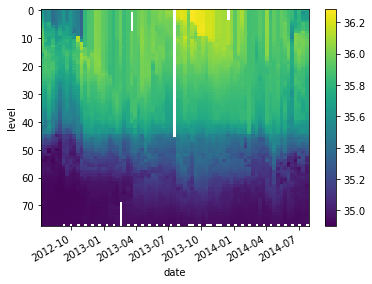

In [10]:
da_salinity.plot(yincrease=False)

Attributes can be used to store metadata. What metadata should you store? The [CF Conventions](http://cfconventions.org/Data/cf-conventions/cf-conventions-1.7/cf-conventions.html#_description_of_the_data) are a great resource for thinking about climate metadata. Below we define two of the required CF-conventions attributes.

In [11]:
da_salinity.attrs['units'] = 'PSU'
da_salinity.attrs['standard_name'] = 'sea_water_salinity'
da_salinity

<xarray.DataArray (level: 78, date: 75)>
array([[35.6389389 , 35.51495743, 35.57297134, ..., 35.82093811,
        35.77793884, 35.66891098],
       [35.63393784, 35.5219574 , 35.57397079, ..., 35.81093216,
        35.58389664, 35.66791153],
       [35.6819458 , 35.52595901, 35.57297134, ..., 35.79592896,
        35.66290665, 35.66591263],
       ...,
       [34.91585922, 34.92390442, 34.92390442, ..., 34.93481064,
        34.94081116, 34.94680786],
       [34.91585922, 34.92390442, 34.92190552, ..., 34.93280792,
        34.93680954, 34.94380951],
       [34.91785812, 34.92390442, 34.92390442, ...,         nan,
        34.93680954,         nan]])
Coordinates:
  * level    (level) int64 0 1 2 3 4 5 6 7 8 9 ... 68 69 70 71 72 73 74 75 76 77
  * date     (date) datetime64[ns] 2012-07-13T22:33:06.019200 ... 2014-07-24T...
Attributes:
    units:          PSU
    standard_name:  sea_water_salinity

Now if we plot the data again, the name and units are automatically attached to the figure.

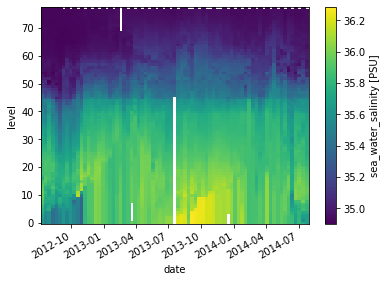

In [12]:
da_salinity.plot()

<a name="Datasets"></a>
## Datasets

A `Dataset` holds many `DataArrays` which potentially can share coordinates. In analogy to `Pandas`:

```
pandas.Series : pandas.Dataframe :: xarray.DataArray : xarray.Dataset
```

Constructing `Datasets` manually is a bit more involved in terms of syntax. The `Dataset` constructor takes three arguments:

*    `data_vars` should be a dictionary with each key as the name of the variable and each value as one of:

    *    A `DataArray` or Variable

    *    A tuple of the form `(dims, data[, attrs])`, which is converted into arguments for Variable

    *    A `Pandas` object, which is converted into a `DataArray`

    *    A 1D array or list, which is interpreted as values for a one dimensional coordinate variable along the same dimension as it’s name

*    `coords` should be a dictionary of the same form as `data_vars`.

*    `attrs` should be a dictionary.

Let’s put together a `Dataset` with temperature, salinity and pressure all together!

In [13]:
argo = xr.Dataset(
    data_vars={
        'salinity':    (('level', 'date'), S),
        'temperature': (('level', 'date'), T),
        'pressure':    (('level', 'date'), P)
    },
    coords={
        'level': levels,
        'date': date
    }
)
argo

<xarray.Dataset>
Dimensions:      (level: 78, date: 75)
Coordinates:
  * level        (level) int64 0 1 2 3 4 5 6 7 8 ... 69 70 71 72 73 74 75 76 77
  * date         (date) datetime64[ns] 2012-07-13T22:33:06.019200 ... 2014-07...
Data variables:
    salinity     (level, date) float64 35.64 35.51 35.57 35.4 ... nan 34.94 nan
    temperature  (level, date) float64 18.97 18.44 19.1 19.79 ... nan 3.714 nan
    pressure     (level, date) float64 6.8 6.1 6.5 5.0 ... 2e+03 nan 2e+03 nan

What about `lon` and `lat`? We forgot them in the creation process, but we can add them after the fact.

In [14]:
argo.coords['lon'] = lon
argo

<xarray.Dataset>
Dimensions:      (level: 78, date: 75, lon: 75)
Coordinates:
  * level        (level) int64 0 1 2 3 4 5 6 7 8 ... 69 70 71 72 73 74 75 76 77
  * date         (date) datetime64[ns] 2012-07-13T22:33:06.019200 ... 2014-07...
  * lon          (lon) float64 -39.13 -37.28 -36.9 ... -33.83 -34.11 -34.38
Data variables:
    salinity     (level, date) float64 35.64 35.51 35.57 35.4 ... nan 34.94 nan
    temperature  (level, date) float64 18.97 18.44 19.1 19.79 ... nan 3.714 nan
    pressure     (level, date) float64 6.8 6.1 6.5 5.0 ... 2e+03 nan 2e+03 nan

That was not quite right as we want `lon` to have dimension `date`:

In [15]:
del argo['lon']
argo.coords['lon'] = ('date', lon)
argo.coords['lat'] = ('date', lat)
argo

<xarray.Dataset>
Dimensions:      (level: 78, date: 75)
Coordinates:
  * level        (level) int64 0 1 2 3 4 5 6 7 8 ... 69 70 71 72 73 74 75 76 77
  * date         (date) datetime64[ns] 2012-07-13T22:33:06.019200 ... 2014-07...
    lon          (date) float64 -39.13 -37.28 -36.9 ... -33.83 -34.11 -34.38
    lat          (date) float64 47.19 46.72 46.45 46.23 ... 42.6 42.46 42.38
Data variables:
    salinity     (level, date) float64 35.64 35.51 35.57 35.4 ... nan 34.94 nan
    temperature  (level, date) float64 18.97 18.44 19.1 19.79 ... nan 3.714 nan
    pressure     (level, date) float64 6.8 6.1 6.5 5.0 ... 2e+03 nan 2e+03 nan

## Coordinates vs. Data Variables

Data variables can be modified through arithmentic operations or other functions. Coordinates are always keept the same.

In [16]:
argo * 10000

<xarray.Dataset>
Dimensions:      (level: 78, date: 75)
Coordinates:
  * level        (level) int64 0 1 2 3 4 5 6 7 8 ... 69 70 71 72 73 74 75 76 77
  * date         (date) datetime64[ns] 2012-07-13T22:33:06.019200 ... 2014-07...
    lon          (date) float64 -39.13 -37.28 -36.9 ... -33.83 -34.11 -34.38
    lat          (date) float64 47.19 46.72 46.45 46.23 ... 42.6 42.46 42.38
Data variables:
    salinity     (level, date) float64 3.564e+05 3.551e+05 ... 3.494e+05 nan
    temperature  (level, date) float64 1.897e+05 1.844e+05 ... 3.714e+04 nan
    pressure     (level, date) float64 6.8e+04 6.1e+04 6.5e+04 ... nan 2e+07 nan

Clearly `lon` and `lat` are coordinates rather than data variables. We can change their status as follows:

In [17]:
argo = argo.set_coords(['lon', 'lat'])
argo

<xarray.Dataset>
Dimensions:      (level: 78, date: 75)
Coordinates:
  * level        (level) int64 0 1 2 3 4 5 6 7 8 ... 69 70 71 72 73 74 75 76 77
  * date         (date) datetime64[ns] 2012-07-13T22:33:06.019200 ... 2014-07...
    lon          (date) float64 -39.13 -37.28 -36.9 ... -33.83 -34.11 -34.38
    lat          (date) float64 47.19 46.72 46.45 46.23 ... 42.6 42.46 42.38
Data variables:
    salinity     (level, date) float64 35.64 35.51 35.57 35.4 ... nan 34.94 nan
    temperature  (level, date) float64 18.97 18.44 19.1 19.79 ... nan 3.714 nan
    pressure     (level, date) float64 6.8 6.1 6.5 5.0 ... 2e+03 nan 2e+03 nan

The bold font (or `*` symbol depending on your version of `xarray`) in the representation above indicates that `level` and `date` are “dimension coordinates” (they describe the coordinates associated with data variable axes, while `lon` and `lat` are “non-dimension coordinates”. We can make any variable a non-dimension coordinate.

Alternatively, we could have assigned `lon` and `lat` directly to `coords` as follows:

In [18]:
argo.coords['lon'] = ('date', lon)
argo.coords['lat'] = ('date', lat)

## Selecting Data (Indexing)

We can always use regular `numpy` indexing and slicing on `DataArrays`

In [19]:
argo.salinity[2]

<xarray.DataArray 'salinity' (date: 75)>
array([35.6819458 , 35.52595901, 35.57297134, 35.40494537, 35.45091629,
       35.50192261, 35.62397766, 35.51696014, 35.62797546, 35.52292252,
       35.47383118, 35.33785629, 35.81896591, 35.88694   , 35.90187836,
       36.02391815, 36.00475693, 35.94187927, 35.91583252, 35.86392212,
       35.81995392, 35.88601303, 35.95079422, 35.84091568, 35.87992477,
               nan, 35.92179108, 35.96979141, 36.0008316 , 35.98083115,
       35.92887878, 35.98091888, 35.9838829 , 36.01884842, 35.99092484,
       36.04689026, 36.04185867,         nan, 36.19193268, 36.22789764,
       36.20986557, 35.97589874, 36.2779007 , 36.25889969, 36.2418251 ,
       36.23685837, 36.19781876, 36.19785309, 36.17692184, 36.1048851 ,
       36.11392212, 36.09080505,         nan, 36.05675888, 35.93374634,
       36.04291534, 36.10183716, 35.97779083, 35.86592102, 35.87791824,
       35.88392258, 35.92078781, 35.88601303, 36.05178833, 35.85883713,
       35.94878769, 35.8938446 , 35.94379425, 35.90884018, 35.84893036,
       35.83496857, 35.71691132, 35.79592896, 35.66290665, 35.66591263])
Coordinates:
    level    int64 2
  * date     (date) datetime64[ns] 2012-07-13T22:33:06.019200 ... 2014-07-24T...
    lon      (date) float64 -39.13 -37.28 -36.9 -36.89 ... -33.83 -34.11 -34.38
    lat      (date) float64 47.19 46.72 46.45 46.23 ... 42.72 42.6 42.46 42.38

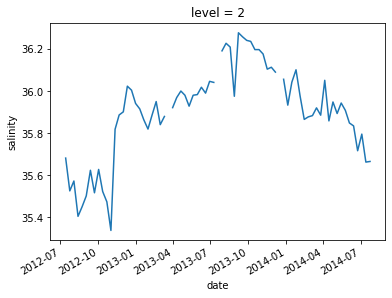

In [20]:
argo.salinity[2].plot()

In [21]:
argo.salinity[:, 10]

<xarray.DataArray 'salinity' (level: 78)>
array([35.47483063, 35.47483063, 35.47383118, 35.47383118, 35.47383118,
       35.47483063, 35.48183441, 35.47983551, 35.4948349 , 35.51083755,
       36.13380051, 36.09579849, 35.95479965, 35.93979645, 35.8958931 ,
       35.86388397, 35.87788773, 35.88188934, 35.90379333, 35.9067955 ,
       35.86588669, 35.8588829 , 35.86088181, 35.85188293, 35.85788345,
       35.82787323, 35.78786469, 35.73185349, 35.69784927, 35.67684174,
       35.677845  , 35.65784073, 35.64083481, 35.6238327 , 35.59682846,
       35.57782364, 35.56182098, 35.55781937, 35.52181625, 35.49881363,
       35.51381302, 35.49981308, 35.47280884, 35.47880936, 35.44780731,
       35.39379501, 35.35879135, 35.28778076, 35.21878052, 35.20677567,
       35.17777252, 35.15076828, 35.07276535, 35.01475525, 34.9797554 ,
       35.0117569 , 35.03975677, 35.05575562, 35.00975037, 34.96175385,
       34.96775055, 34.95075226, 34.93775177, 34.93375015, 34.93775558,
       34.9247551 , 34.92175674, 34.91975403, 34.91975403, 34.91975403,
       34.92176056, 34.92375946, 34.92575836, 34.92575836, 34.92475891,
       34.93076324, 34.92176437,         nan])
Coordinates:
  * level    (level) int64 0 1 2 3 4 5 6 7 8 9 ... 68 69 70 71 72 73 74 75 76 77
    date     datetime64[ns] 2012-10-22T02:50:32.006400
    lon      float64 -32.97
    lat      float64 44.13

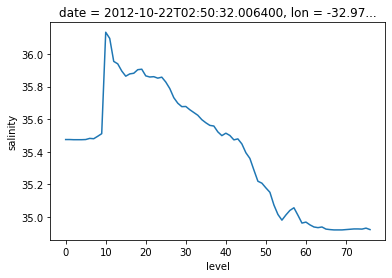

In [22]:
argo.salinity[:, 10].plot()

However, it is often much more powerful to use xarray’s `.sel()` method to use label-based indexing.

In [23]:
argo.salinity.sel(level=2)

<xarray.DataArray 'salinity' (date: 75)>
array([35.6819458 , 35.52595901, 35.57297134, 35.40494537, 35.45091629,
       35.50192261, 35.62397766, 35.51696014, 35.62797546, 35.52292252,
       35.47383118, 35.33785629, 35.81896591, 35.88694   , 35.90187836,
       36.02391815, 36.00475693, 35.94187927, 35.91583252, 35.86392212,
       35.81995392, 35.88601303, 35.95079422, 35.84091568, 35.87992477,
               nan, 35.92179108, 35.96979141, 36.0008316 , 35.98083115,
       35.92887878, 35.98091888, 35.9838829 , 36.01884842, 35.99092484,
       36.04689026, 36.04185867,         nan, 36.19193268, 36.22789764,
       36.20986557, 35.97589874, 36.2779007 , 36.25889969, 36.2418251 ,
       36.23685837, 36.19781876, 36.19785309, 36.17692184, 36.1048851 ,
       36.11392212, 36.09080505,         nan, 36.05675888, 35.93374634,
       36.04291534, 36.10183716, 35.97779083, 35.86592102, 35.87791824,
       35.88392258, 35.92078781, 35.88601303, 36.05178833, 35.85883713,
       35.94878769, 35.8938446 , 35.94379425, 35.90884018, 35.84893036,
       35.83496857, 35.71691132, 35.79592896, 35.66290665, 35.66591263])
Coordinates:
    level    int64 2
  * date     (date) datetime64[ns] 2012-07-13T22:33:06.019200 ... 2014-07-24T...
    lon      (date) float64 -39.13 -37.28 -36.9 -36.89 ... -33.83 -34.11 -34.38
    lat      (date) float64 47.19 46.72 46.45 46.23 ... 42.72 42.6 42.46 42.38

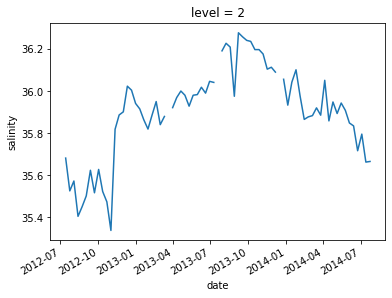

In [24]:
argo.salinity.sel(level=2).plot()

In [25]:
argo.salinity.sel(date='2012-10-22')

<xarray.DataArray 'salinity' (level: 78, date: 1)>
array([[35.47483063],
       [35.47483063],
       [35.47383118],
       [35.47383118],
       [35.47383118],
       [35.47483063],
       [35.48183441],
       [35.47983551],
       [35.4948349 ],
       [35.51083755],
       [36.13380051],
       [36.09579849],
       [35.95479965],
       [35.93979645],
       [35.8958931 ],
       [35.86388397],
       [35.87788773],
       [35.88188934],
       [35.90379333],
       [35.9067955 ],
...
       [35.00975037],
       [34.96175385],
       [34.96775055],
       [34.95075226],
       [34.93775177],
       [34.93375015],
       [34.93775558],
       [34.9247551 ],
       [34.92175674],
       [34.91975403],
       [34.91975403],
       [34.91975403],
       [34.92176056],
       [34.92375946],
       [34.92575836],
       [34.92575836],
       [34.92475891],
       [34.93076324],
       [34.92176437],
       [        nan]])
Coordinates:
  * level    (level) int64 0 1 2 3 4 5 6 7 8 9 ... 68 69 70 71 72 73 74 75 76 77
  * date     (date) datetime64[ns] 2012-10-22T02:50:32.006400
    lon      (date) float64 -32.97
    lat      (date) float64 44.13

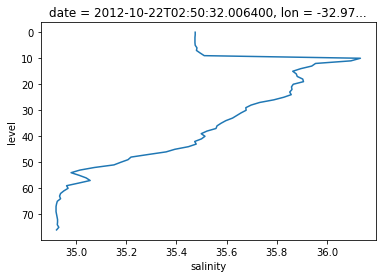

In [26]:
argo.salinity.sel(date='2012-10-22').plot(y='level', yincrease=False)

`.sel()` also supports slicing. Unfortunately we have to use a somewhat awkward syntax, but it still works.

In [27]:
argo.salinity.sel(date=slice('2012-10-01', '2012-12-01'))

<xarray.DataArray 'salinity' (level: 78, date: 7)>
array([[35.63097763, 35.52592468, 35.47483063, 35.33785629, 35.81896591,
        35.8889389 , 35.90187836],
       [35.63097763, 35.52292252, 35.47483063, 35.33685684, 35.81796646,
        35.88793945, 35.90187836],
       [35.62797546, 35.52292252, 35.47383118, 35.33785629, 35.81896591,
        35.88694   , 35.90187836],
       [35.62697601, 35.52192307, 35.47383118, 35.33785629, 35.81896591,
        35.89193726, 35.90187836],
       [35.62797546, 35.52192307, 35.47383118, 35.33785629, 35.81996536,
        35.88993835, 35.90187836],
       [35.62897873, 35.52292252, 35.47483063, 35.33785629, 35.81996536,
        35.88993835, 35.90187836],
       [35.62997818, 35.51892471, 35.48183441, 35.33785629, 35.81996536,
        35.88993835, 35.90187836],
       [35.63197708, 35.44991302, 35.47983551, 35.33785629, 35.81996536,
        35.89683914, 35.90187836],
       [35.63097763, 35.38090134, 35.4948349 , 35.33785629, 35.81896591,
        35.89583969, 35.90187836],
       [35.62697601, 35.58792114, 35.51083755, 35.33985519, 35.82497025,
        35.89683914, 35.90187836],
...
       [34.91690445, 34.92385483, 34.91975403, 34.91980362, 34.92385483,
        34.93680573, 34.93885422],
       [34.92190552, 34.92485428, 34.91975403, 34.92080688, 34.92485428,
        34.94480515, 34.9328537 ],
       [34.92390442, 34.92285538, 34.92176056, 34.92280579, 34.92985535,
        34.93280411, 34.92785645],
       [34.92390442, 34.92385483, 34.92375946, 34.92480469, 34.92685318,
        34.93780899, 34.92485428],
       [34.92390442, 34.92285538, 34.92575836, 34.92181015, 34.92085648,
        34.93680954, 34.92385483],
       [34.92590332, 34.9288559 , 34.92575836, 34.92181015, 34.92685318,
        34.93481064, 34.92585373],
       [34.92490387, 34.92785645, 34.92475891, 34.92781067, 34.93385696,
        34.93380737, 34.92385864],
       [34.92190552, 34.92385864, 34.93076324, 34.9268074 , 34.93585968,
        34.93481064, 34.92985916],
       [34.92090607, 34.92185974, 34.92176437, 34.9228096 , 34.93285751,
        34.93180847, 34.92786026],
       [        nan, 34.91985703,         nan, 34.92181015,         nan,
        34.92181015,         nan]])
Coordinates:
  * level    (level) int64 0 1 2 3 4 5 6 7 8 9 ... 68 69 70 71 72 73 74 75 76 77
  * date     (date) datetime64[ns] 2012-10-02T03:00:17.971200 ... 2012-12-01T...
    lon      (date) float64 -34.46 -33.78 -32.97 -32.55 -32.43 -32.29 -32.17
    lat      (date) float64 44.96 44.68 44.13 43.64 43.07 42.66 42.51

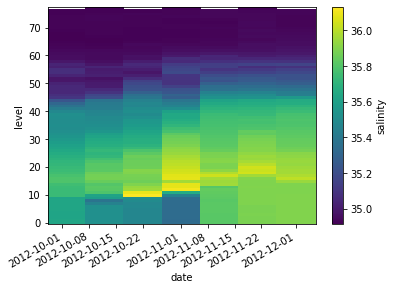

In [28]:
argo.salinity.sel(date=slice('2012-10-01', '2012-12-01')).plot()

`.sel()` also works on the whole Dataset

In [29]:
argo.sel(date='2012-10-22')

<xarray.Dataset>
Dimensions:      (level: 78, date: 1)
Coordinates:
  * level        (level) int64 0 1 2 3 4 5 6 7 8 ... 69 70 71 72 73 74 75 76 77
  * date         (date) datetime64[ns] 2012-10-22T02:50:32.006400
    lon          (date) float64 -32.97
    lat          (date) float64 44.13
Data variables:
    salinity     (level, date) float64 35.47 35.47 35.47 ... 34.93 34.92 nan
    temperature  (level, date) float64 17.13 17.13 17.13 ... 3.736 3.639 nan
    pressure     (level, date) float64 6.4 10.3 15.4 ... 1.9e+03 1.951e+03 nan

## Computation

`Xarray` `DataArrays` and `Datasets` work seamlessly with arithmetic operators and `numpy` array functions.

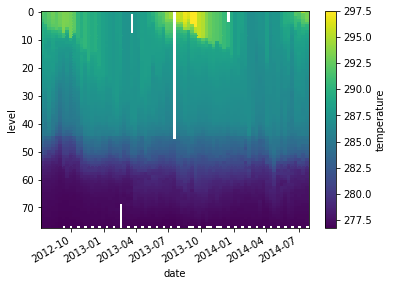

In [30]:
temp_kelvin = argo.temperature + 273.15
temp_kelvin.plot(yincrease=False)

We can also combine multiple `Xarray` datasets in arithemtic operations:

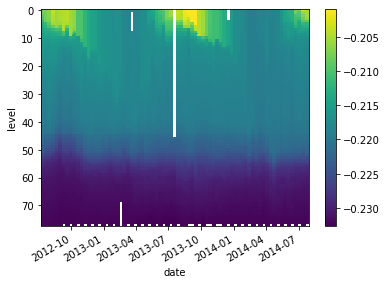

In [31]:
g = 9.8
buoyancy = g * (2e-4 * argo.temperature - 7e-4 * argo.salinity)
buoyancy.plot(yincrease=False)

# Broadcasting, Aligment, and Combining Data

## Broadcasting

Broadcasting arrays in `numpy` is a nightmare. It is much easier when the data axes are labeled!

This is a useless calculation, but it illustrates how perfoming an operation on arrays with differenty coordinates will result in automatic broadcasting.

In [32]:
level_times_lat = argo.level * argo.lat
level_times_lat

<xarray.DataArray (level: 78, date: 75)>
array([[   0.   ,    0.   ,    0.   , ...,    0.   ,    0.   ,    0.   ],
       [  47.187,   46.716,   46.45 , ...,   42.601,   42.457,   42.379],
       [  94.374,   93.432,   92.9  , ...,   85.202,   84.914,   84.758],
       ...,
       [3539.025, 3503.7  , 3483.75 , ..., 3195.075, 3184.275, 3178.425],
       [3586.212, 3550.416, 3530.2  , ..., 3237.676, 3226.732, 3220.804],
       [3633.399, 3597.132, 3576.65 , ..., 3280.277, 3269.189, 3263.183]])
Coordinates:
  * level    (level) int64 0 1 2 3 4 5 6 7 8 9 ... 68 69 70 71 72 73 74 75 76 77
  * date     (date) datetime64[ns] 2012-07-13T22:33:06.019200 ... 2014-07-24T...
    lon      (date) float64 -39.13 -37.28 -36.9 -36.89 ... -33.83 -34.11 -34.38
    lat      (date) float64 47.19 46.72 46.45 46.23 ... 42.72 42.6 42.46 42.38

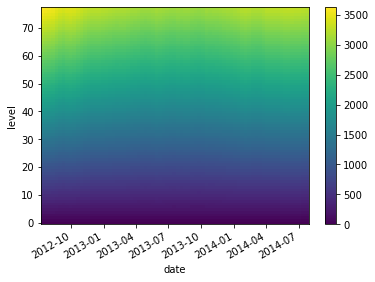

In [33]:
level_times_lat.plot()

## Alignment

If you try to perform operations on `DataArrays` that share a dimension name, `Xarray` will try to align them first. This works nearly identically to `Pandas`, except that there can be multiple dimensions to align over.

To see how alignment works, we will create some subsets of our original data.

In [34]:
sa_surf = argo.salinity.isel(level=slice(0, 20))
sa_mid = argo.salinity.isel(level=slice(10, 30))

By default, when we combine multiple arrays in mathematical operations, `Xarray` performs an “inner join”.

In [35]:
(sa_surf * sa_mid).level

<xarray.DataArray 'level' (level: 10)>
array([10, 11, 12, 13, 14, 15, 16, 17, 18, 19])
Coordinates:
  * level    (level) int64 10 11 12 13 14 15 16 17 18 19

We can override this behavior by manually aligning the data using an *outer* joint:

In [36]:
sa_surf_outer, sa_mid_outer = xr.align(sa_surf, sa_mid, join='outer')
sa_surf_outer.level

<xarray.DataArray 'level' (level: 30)>
array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29])
Coordinates:
  * level    (level) int64 0 1 2 3 4 5 6 7 8 9 ... 20 21 22 23 24 25 26 27 28 29

As we can see, missing data (`NaN`s) have been filled in where the array was extended.

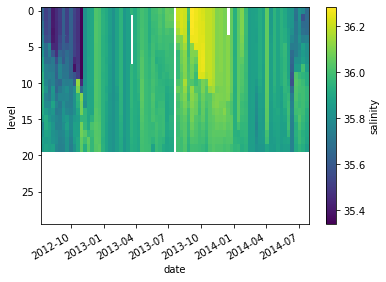

In [37]:
sa_surf_outer.plot(yincrease=False)

We can also use `join='right'` and `join='left'`.

<a name="Concat_Merge"></a>
## Combing Data: Concat and Merge

The ability to combine many smaller arrays into a single big `Dataset` is one of the main advantages of `Xarray`. To take advantage of this, we need to learn two operations that help us combine data:

*    `xr.concat`: to concatenate multiple arrays into one bigger array along their dimensions

*    `xr.merge`: to combine multiple different arrays into a dataset

First let’s look at concat. Let’s re-combine the subsetted data from the previous step.

In [38]:
sa_surf_mid = xr.concat([sa_surf, sa_mid], dim='level')
sa_surf_mid

<xarray.DataArray 'salinity' (level: 40, date: 75)>
array([[35.6389389 , 35.51495743, 35.57297134, ..., 35.82093811,
        35.77793884, 35.66891098],
       [35.63393784, 35.5219574 , 35.57397079, ..., 35.81093216,
        35.58389664, 35.66791153],
       [35.6819458 , 35.52595901, 35.57297134, ..., 35.79592896,
        35.66290665, 35.66591263],
       ...,
       [35.78895187, 35.7829895 , 35.85100555, ..., 35.84291458,
        35.81891251, 35.7779007 ],
       [35.76794815, 35.75598526, 35.84500504, ..., 35.84891891,
        35.83391571, 35.76390076],
       [35.75194168, 35.71097565, 35.83100128, ..., 35.80690765,
        35.85292053, 35.75489807]])
Coordinates:
  * level    (level) int64 0 1 2 3 4 5 6 7 8 9 ... 20 21 22 23 24 25 26 27 28 29
  * date     (date) datetime64[ns] 2012-07-13T22:33:06.019200 ... 2014-07-24T...
    lon      (date) float64 -39.13 -37.28 -36.9 -36.89 ... -33.83 -34.11 -34.38
    lat      (date) float64 47.19 46.72 46.45 46.23 ... 42.72 42.6 42.46 42.38

**Warning**

`Xarray` won’t check the values of the coordinates before `concat`. It will just stick everything together into a new array.

In this case, we had overlapping data. We can see this by looking at the `level` coordinate.

In [39]:
sa_surf_mid.level

<xarray.DataArray 'level' (level: 40)>
array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25,
       26, 27, 28, 29])
Coordinates:
  * level    (level) int64 0 1 2 3 4 5 6 7 8 9 ... 20 21 22 23 24 25 26 27 28 29

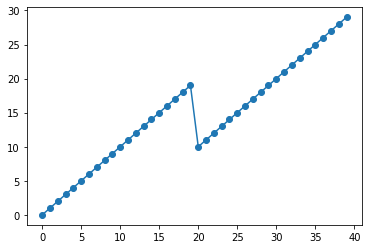

In [40]:
plt.plot(sa_surf_mid.level.values, marker='o')

We can also `concat` data along a *new* dimension, e.g.

In [41]:
sa_concat_new = xr.concat([sa_surf, sa_mid], dim='newdim')
sa_concat_new

<xarray.DataArray 'salinity' (newdim: 2, level: 30, date: 75)>
array([[[35.6389389 , 35.51495743, 35.57297134, ..., 35.82093811,
         35.77793884, 35.66891098],
        [35.63393784, 35.5219574 , 35.57397079, ..., 35.81093216,
         35.58389664, 35.66791153],
        [35.6819458 , 35.52595901, 35.57297134, ..., 35.79592896,
         35.66290665, 35.66591263],
        ...,
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan]],

       [[        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        ...,
        [35.78895187, 35.7829895 , 35.85100555, ..., 35.84291458,
         35.81891251, 35.7779007 ],
        [35.76794815, 35.75598526, 35.84500504, ..., 35.84891891,
         35.83391571, 35.76390076],
        [35.75194168, 35.71097565, 35.83100128, ..., 35.80690765,
         35.85292053, 35.75489807]]])
Coordinates:
  * level    (level) int64 0 1 2 3 4 5 6 7 8 9 ... 20 21 22 23 24 25 26 27 28 29
  * date     (date) datetime64[ns] 2012-07-13T22:33:06.019200 ... 2014-07-24T...
    lon      (date) float64 -39.13 -37.28 -36.9 -36.89 ... -33.83 -34.11 -34.38
    lat      (date) float64 47.19 46.72 46.45 46.23 ... 42.72 42.6 42.46 42.38
Dimensions without coordinates: newdim

Note that the data were aligned using an *outer* join along the non-concat dimensions.

Instead of specifying a new dimension name, we can pass a new Pandas index object explicitly to `concat`. This will create a new dimension coordinate and corresponding index.

We can merge both `DataArrays` and `Datasets`.

In [42]:
xr.merge([argo.salinity, argo.temperature])

<xarray.Dataset>
Dimensions:      (level: 78, date: 75)
Coordinates:
  * level        (level) int64 0 1 2 3 4 5 6 7 8 ... 69 70 71 72 73 74 75 76 77
  * date         (date) datetime64[ns] 2012-07-13T22:33:06.019200 ... 2014-07...
    lon          (date) float64 -39.13 -37.28 -36.9 ... -33.83 -34.11 -34.38
    lat          (date) float64 47.19 46.72 46.45 46.23 ... 42.6 42.46 42.38
Data variables:
    salinity     (level, date) float64 35.64 35.51 35.57 35.4 ... nan 34.94 nan
    temperature  (level, date) float64 18.97 18.44 19.1 19.79 ... nan 3.714 nan

If the data are not aligned, they will be aligned before merge. We can specify the join options in `merge`.

In [43]:
xr.merge([
    argo.salinity.sel(level=slice(0, 30)),
    argo.temperature.sel(level=slice(30, None))
])

<xarray.Dataset>
Dimensions:      (level: 78, date: 75)
Coordinates:
  * level        (level) int64 0 1 2 3 4 5 6 7 8 ... 69 70 71 72 73 74 75 76 77
  * date         (date) datetime64[ns] 2012-07-13T22:33:06.019200 ... 2014-07...
    lon          (date) float64 -39.13 -37.28 -36.9 ... -33.83 -34.11 -34.38
    lat          (date) float64 47.19 46.72 46.45 46.23 ... 42.6 42.46 42.38
Data variables:
    salinity     (level, date) float64 35.64 35.51 35.57 35.4 ... nan nan nan
    temperature  (level, date) float64 nan nan nan nan ... 3.728 nan 3.714 nan

In [44]:
xr.merge([
    argo.salinity.sel(level=slice(0, 30)),
    argo.temperature.sel(level=slice(30, None))
], join='left')

<xarray.Dataset>
Dimensions:      (level: 31, date: 75)
Coordinates:
  * level        (level) int64 0 1 2 3 4 5 6 7 8 ... 22 23 24 25 26 27 28 29 30
  * date         (date) datetime64[ns] 2012-07-13T22:33:06.019200 ... 2014-07...
    lon          (date) float64 -39.13 -37.28 -36.9 ... -33.83 -34.11 -34.38
    lat          (date) float64 47.19 46.72 46.45 46.23 ... 42.6 42.46 42.38
Data variables:
    salinity     (level, date) float64 35.64 35.51 35.57 ... 35.78 35.83 35.76
    temperature  (level, date) float64 nan nan nan nan ... 13.59 13.74 13.31

<a name="Reductions"></a>
## Reductions

Just like in `numpy`, we can reduce `Xarray` `DataArrays` along any number of axes:

In [45]:
argo.temperature.mean(axis=0)

<xarray.DataArray 'temperature' (date: 75)>
array([10.88915385, 10.7282564 , 10.9336282 , 10.75679484, 10.38166666,
       10.08619236, 10.58194804, 10.50066671, 10.56841555, 10.53705122,
       10.81131168, 11.01932052, 11.39205196, 11.40823073, 11.3642208 ,
       11.35821797, 11.39444157, 11.10514098, 11.02870125, 10.80894868,
       10.93076625, 11.01069231, 11.88195654, 10.57373078, 10.66359736,
       10.56573237, 11.08854546, 10.87921792, 11.21384416, 11.24991028,
       11.29168825, 11.06203848, 11.32829864, 11.20401279, 11.25300001,
       11.32106403, 11.40112986,  6.07053117, 11.7748052 , 11.7466795 ,
       12.03732056, 11.92653251, 12.08844156, 12.20543591, 12.23402598,
       12.03365387, 11.9919221 , 11.92087012, 11.84273071, 11.79711684,
       11.7895325 , 11.55385894, 11.19083561, 11.266282  , 11.0611948 ,
       11.0307179 , 11.06566232, 10.79799995, 10.787     , 10.41173077,
       10.44170127, 10.32649998, 10.38242857, 10.88080769, 10.86177921,
       10.98787178, 10.93602596, 10.73039743, 11.09251948, 10.93983334,
       10.65942862, 11.01814097, 11.21918184, 11.19080765, 11.13364934])
Coordinates:
  * date     (date) datetime64[ns] 2012-07-13T22:33:06.019200 ... 2014-07-24T...
    lon      (date) float64 -39.13 -37.28 -36.9 -36.89 ... -33.83 -34.11 -34.38
    lat      (date) float64 47.19 46.72 46.45 46.23 ... 42.72 42.6 42.46 42.38

In [46]:
argo.temperature.mean(axis=1)

<xarray.DataArray 'temperature' (level: 78)>
array([17.60172602, 17.57223609, 17.5145833 , 17.42326395, 17.24943838,
       17.03730134, 16.76787661, 16.44609588, 16.17439195, 16.04501356,
       15.65827023, 15.4607296 , 15.26114862, 15.12489191, 14.99133783,
       14.90160808, 14.81990544, 14.74535139, 14.66822971, 14.585027  ,
       14.49732434, 14.41904053, 14.35412163, 14.27102702, 14.19081082,
       14.11487838, 14.04347293, 13.98067566, 13.90994595, 13.83274319,
       13.76139196, 13.69836479, 13.62335132, 13.54185131, 13.46647295,
       13.39395946, 13.32541891, 13.25205403, 13.18131082, 13.10233782,
       12.89268916, 12.67795943, 12.4649189 , 12.2178513 , 11.98270268,
       11.1281081 , 10.80430666, 10.49702667, 10.1749066 ,  9.83453334,
        9.48625332,  9.19793334,  8.66010666,  8.12324001,  7.60221333,
        7.15289333,  6.74250667,  6.39543999,  6.04598667,  5.74538665,
        5.48913333,  5.26604001,  5.08768   ,  4.93479998,  4.77769334,
        4.65368   ,  4.54237334,  4.44274664,  4.35933333,  4.2653784 ,
        4.17290539,  4.08902703,  3.99864865,  3.92163514,  3.85617567,
        3.78916217,  3.72950001,  3.66207691])
Coordinates:
  * level    (level) int64 0 1 2 3 4 5 6 7 8 9 ... 68 69 70 71 72 73 74 75 76 77

However, rather than performing reductions on axes (as in `numpy`), we can perform them on dimensions. This turns out to be a huge convenience

In [47]:
argo_mean = argo.mean(dim='date')
argo_mean

<xarray.Dataset>
Dimensions:      (level: 78)
Coordinates:
  * level        (level) int64 0 1 2 3 4 5 6 7 8 ... 69 70 71 72 73 74 75 76 77
Data variables:
    salinity     (level) float64 35.91 35.9 35.9 35.9 ... 34.94 34.94 34.93
    temperature  (level) float64 17.6 17.57 17.51 17.42 ... 3.789 3.73 3.662
    pressure     (level) float64 6.435 10.57 15.54 ... 1.95e+03 1.999e+03

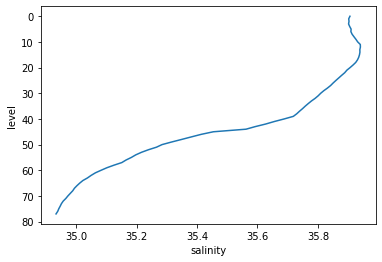

In [48]:
argo_mean.salinity.plot(y='level', yincrease=False)

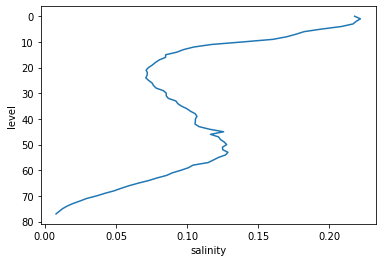

In [49]:
argo_std = argo.std(dim='date')
argo_std.salinity.plot(y='level', yincrease=False)

<a name="Weighted_Reductions"></a>
## Weighted Reductions

Sometimes we want to perform a reduction (e.g. a `mean`) where we assign different weight factors to each point in the array. `Xarray` supports this via [weighted array reductions](http://xarray.pydata.org/en/stable/user-guide/computation.html#weighted-array-reductions).

As a toy example, imagine we want to weight values in the upper ocean more than the lower ocean. We could imagine creating a weight array exponentially proportional to pressure as follows:

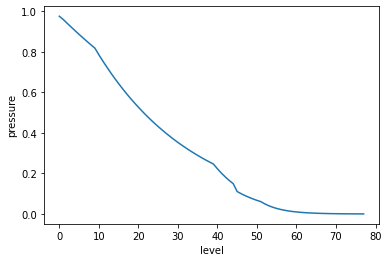

In [50]:
mean_pressure = argo.pressure.mean(dim='date')
p0 = 250  # dbat
weights = np.exp(-mean_pressure / p0)
weights.plot()

The weighted mean over the `level` dimensions is calculated as follows:

In [51]:
temp_weighted_mean = argo.temperature.weighted(weights).mean('level')

Comparing to the unweighted mean, we see the difference:

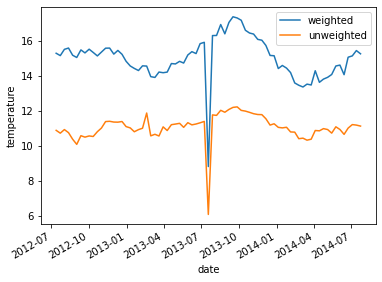

In [52]:
temp_weighted_mean.plot(label='weighted')
argo.temperature.mean(dim='level').plot(label='unweighted')
plt.legend()

<a name="Load_netcdf"></a>
# Loading Data from netCDF Files

NetCDF (Network Common Data Format) is the most widely used format for distributing geoscience data. NetCDF is maintained by the [Unidata](https://www.unidata.ucar.edu/) organization.

Below we quote from the [NetCDF website](https://www.unidata.ucar.edu/software/netcdf/docs/faq.html#whatisit):



---


NetCDF (network Common Data Form) is a set of interfaces for array-oriented data access and a freely distributed collection of data access libraries for C, Fortran, C++, Java, and other languages. The netCDF libraries support a machine-independent format for representing scientific data. Together, the interfaces, libraries, and format support the creation, access, and sharing of scientific data.

NetCDF data is:

*    Self-Describing. A netCDF file includes information about the data it contains.

*    Portable. A netCDF file can be accessed by computers with different ways of storing integers, characters, and floating-point numbers.

*    Scalable. A small subset of a large dataset may be accessed efficiently.

*    Appendable. Data may be appended to a properly structured netCDF file without copying the dataset or redefining its structure.

*    Sharable. One writer and multiple readers may simultaneously access the same netCDF file.

*    Archivable. Access to all earlier forms of netCDF data will be supported by current and future versions of the software.


---



Xarray was designed to make reading netCDF files in python as easy, powerful, and flexible as possible. (See [Xarray netCDF docs](http://xarray.pydata.org/en/latest/io.html#netcdf) for more details.)

Below we download and load some the NASA [GISSTemp](https://data.giss.nasa.gov/gistemp/) global temperature anomaly dataset.

In [63]:
new_key=print(pooch.file_hash("gistemp1200_GHCNv4_ERSSTv5.nc.gz"))


9bb135d807e54d60da60fd346b9fc8c1f735260be6c2a18bf2d107bbed11aa94


In [64]:
gistemp_file = pooch.retrieve(
    'https://data.giss.nasa.gov/pub/gistemp/gistemp1200_GHCNv4_ERSSTv5.nc.gz',
    known_hash=new_key,#'dfc1e6e02aa9151698367a17e82afd30bec0cdd6dfb9c58d131f836949cdb4a8',
    processor=pooch.Decompress(),
)

SHA256 hash of downloaded file: 9bb135d807e54d60da60fd346b9fc8c1f735260be6c2a18bf2d107bbed11aa94
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.
Decompressing '/root/.cache/pooch/d87657ed105a8945c211515b79b884c2-gistemp1200_GHCNv4_ERSSTv5.nc.gz' to '/root/.cache/pooch/d87657ed105a8945c211515b79b884c2-gistemp1200_GHCNv4_ERSSTv5.nc.gz.decomp' using method 'auto'.


In [65]:
ds = xr.open_dataset(gistemp_file)
ds

<xarray.Dataset>
Dimensions:      (lat: 90, lon: 180, time: 1708, nv: 2)
Coordinates:
  * lat          (lat) float32 -89.0 -87.0 -85.0 -83.0 ... 83.0 85.0 87.0 89.0
  * lon          (lon) float32 -179.0 -177.0 -175.0 -173.0 ... 175.0 177.0 179.0
  * time         (time) datetime64[ns] 1880-01-15 1880-02-15 ... 2022-04-15
Dimensions without coordinates: nv
Data variables:
    time_bnds    (time, nv) datetime64[ns] ...
    tempanomaly  (time, lat, lon) float32 ...
Attributes:
    title:        GISTEMP Surface Temperature Analysis
    institution:  NASA Goddard Institute for Space Studies
    source:       http://data.giss.nasa.gov/gistemp/
    Conventions:  CF-1.6
    history:      Created 2022-05-11 09:46:13 by SBBX_to_nc 2.0 - ILAND=1200,...

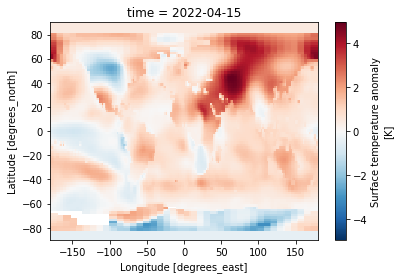

In [66]:
ds.tempanomaly.isel(time=-1).plot()

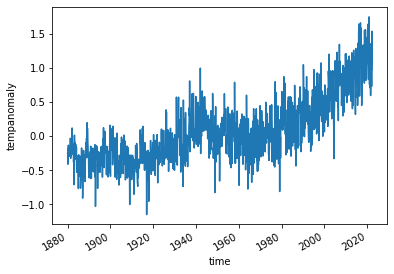

In [67]:
ds.tempanomaly.mean(dim=('lon', 'lat')).plot()

# To Learn More

We've only scratched the surface of what was possible with `Xarray`. If you want to learn more, consider reading the other parts of this `Xarray` tutorial from [An Introduction to Earth and Environmental Data Science](https://earth-env-data-science.github.io/intro.html):

*    [`Xarray` Interpolation, Groupby, Resample, Rolling, and Coarsen](https://earth-env-data-science.github.io/lectures/xarray/xarray-part2.html)
*    [`Xarray` Tips and Tricks](https://earth-env-data-science.github.io/lectures/xarray/xarray_tips_and_tricks.html)
*    And of course, the [official `Xarray` documentation](https://docs.xarray.dev/en/stable/)

# Bonus Exercise 1: Efficiently Manipulating Global Atmospheric Radiation Data with `Xarray`

First, congratulations on making it to the bonus exercises! 😃

This first bonus exercise is guided but very long (it could easily take you more than 30 minutes if you are not used to `Xarray`). If you want to practice manipulating large geoscientific datasets, you're at the right place, but you may want to proceed to the next notebooks if you are more interested in making maps or statistical graphics.

This bonus exercise's goal is to use `Xarray` to analyze top-of-atmosphere radiation data from [NASA’s CERES project](https://ceres.larc.nasa.gov/).

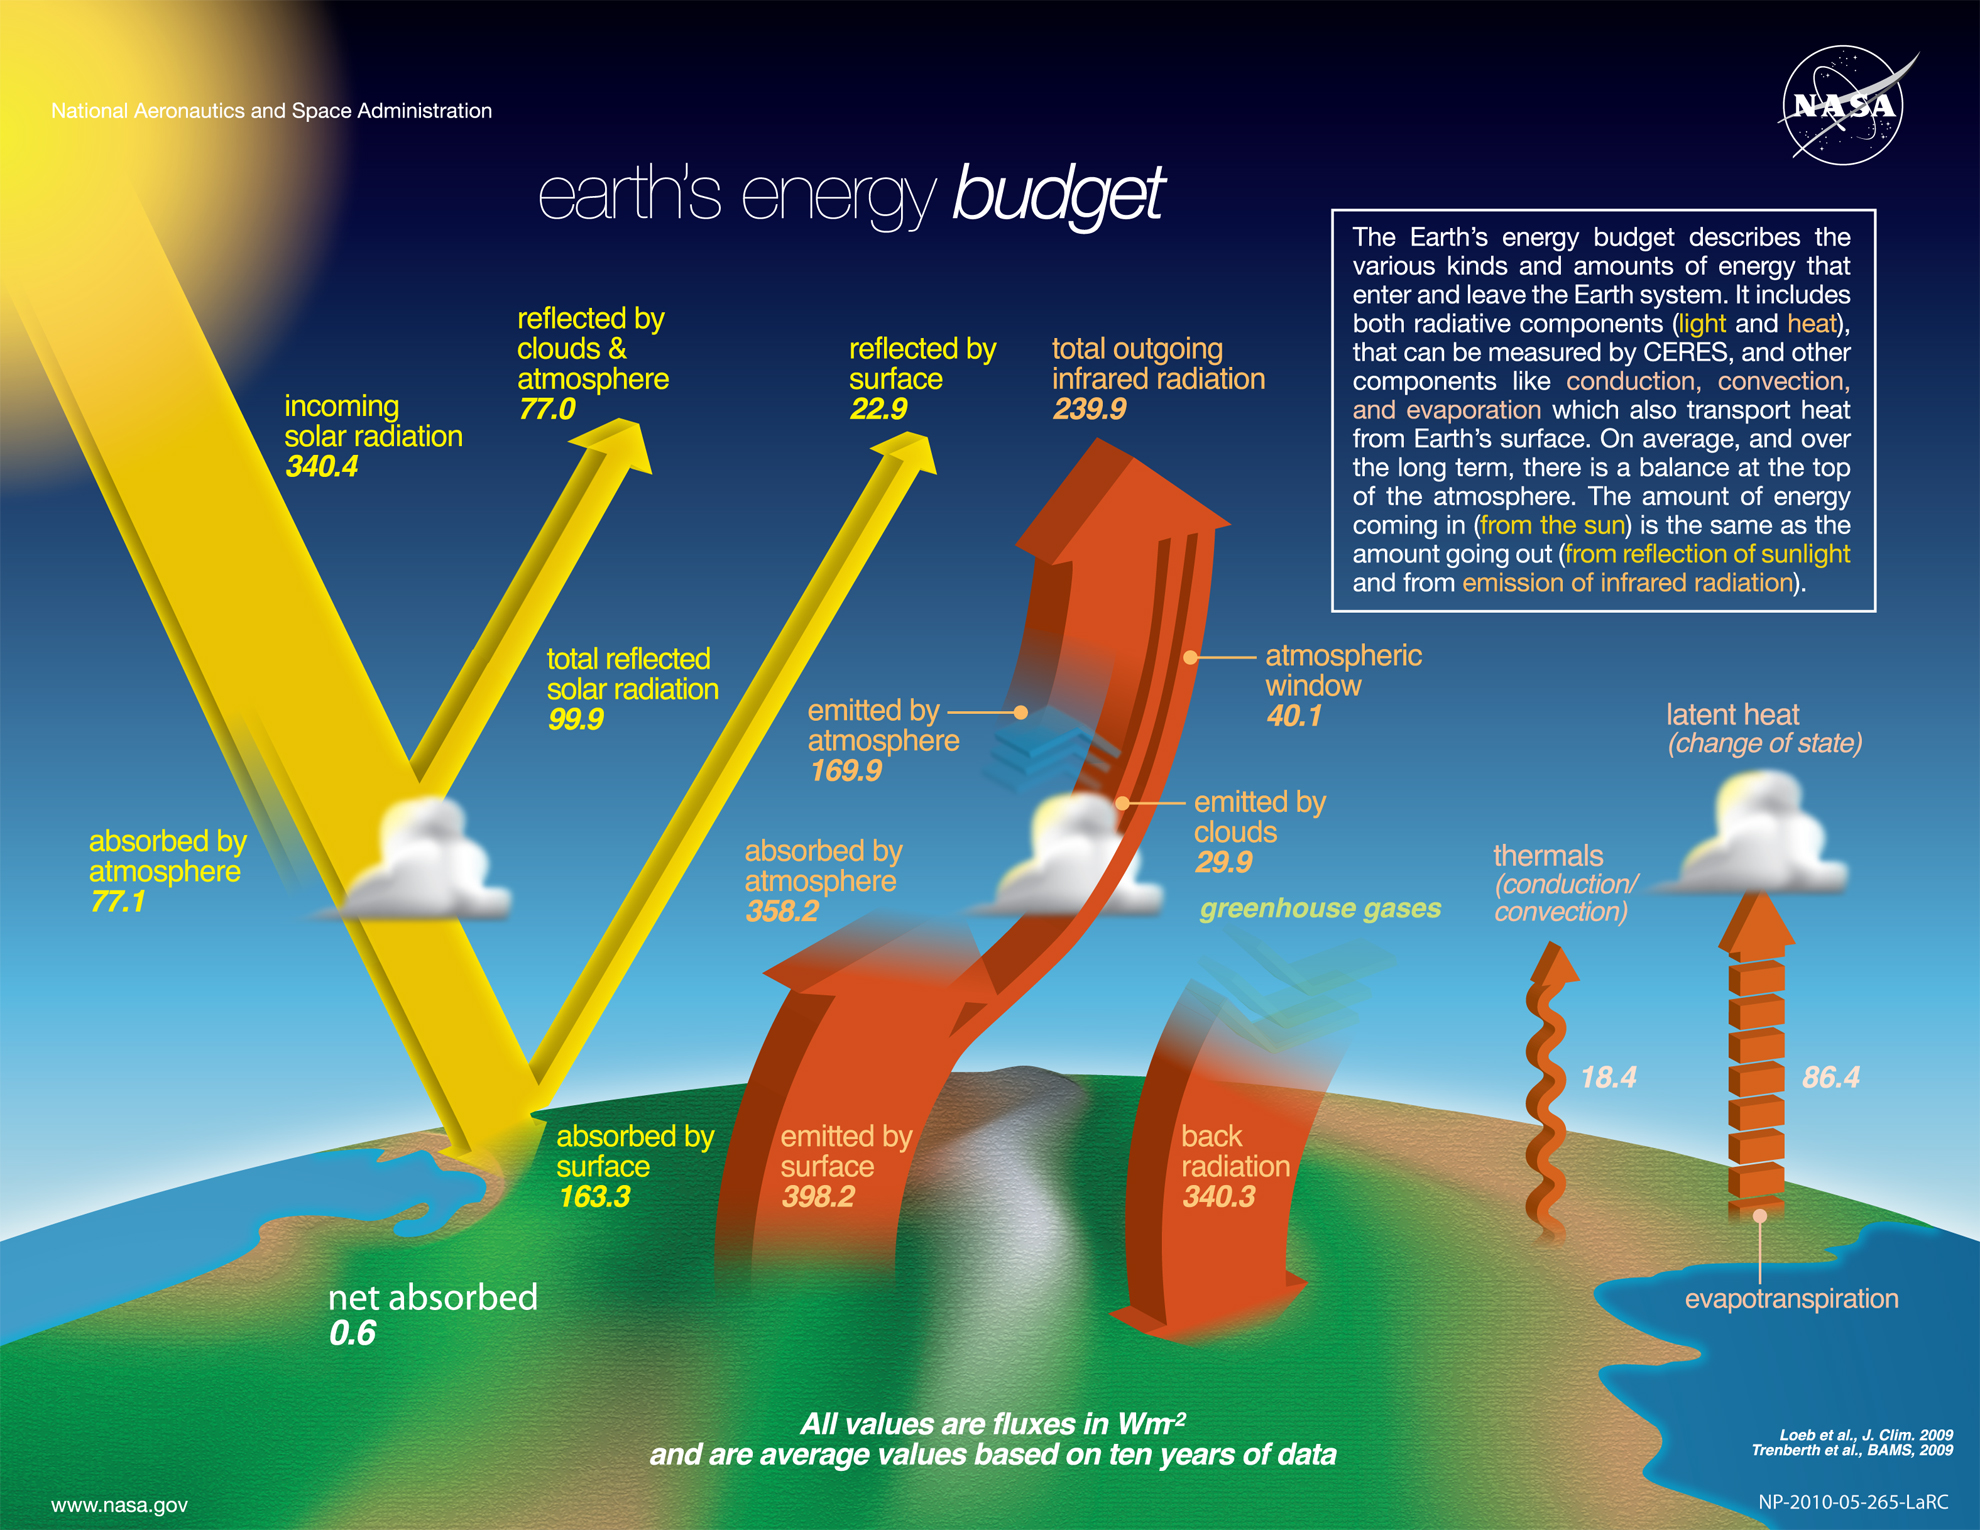

Source: *NASA*, retrieved from: *Wikimedia Commons*

A pre-downloaded and subsetted a portion of the CERES dataset is available here: http://ldeo.columbia.edu/~rpa/CERES_EBAF-TOA_Edition4.0_200003-201701.condensed.nc. The size of the data file is 702.53 MB. It may take a few minutes to download.

If you're curious about CERES, consider reviewing the [CERES FAQs](https://ceres.larc.nasa.gov/resources/faqs) before getting started.

## Part I: Imports

First, download the NETCDF file using `pooch`:

In [55]:
import pooch
fname = pooch.retrieve(
    'https://unils-my.sharepoint.com/:u:/g/personal/tom_beucler_unil_ch/EfwAZJ7K3NVKsM26HpAndB0B1dSP93jgWRx6kbAqKVK8yQ?download=1',
    known_hash='a876cc7106e7dcb1344fbec5dcd7510e5cd947e62049a8cbc188ad05ffe00345'
)
print(fname)

TypeError: ignored

**Q1) Import `numpy`, `matplotlib`, and `xarray`. Set the default figure size to `(12,6)`**

Hint: The documentation to customize Matplotlib figures is [at this link](https://matplotlib.org/stable/tutorials/introductory/customizing.html) 

In [ ]:
# Import the three libraries

In [ ]:
# Change the default figure size to (12,6)

## Part II: Opening Data and Examining Metadata

**Q2) Open the dataset and display its contents**

Hint: Check out the [Loading Data from netCDF Files](#Load_netcdf) section

In [ ]:
# Open the dataset

In [ ]:
# Display its contents

**Q3) Print out the `long_name` attribute of each variable**



In [ ]:
# Print `variable.long_name` for each variable

## Part III: Basic Reductions, Arithmetic, and Plotting

**Q4) Calculate the time-mean of the entire dataset**

Hint: Check out the [Reductions](#Reductions) subsection

In [ ]:
# Calculate time-mean of entire dataset

**Q5) From this, make a 2D plot of the the time-mean, "all-sky", Top-of-Atmosphere longwave flux, shortwave flux, and incoming solar radiation**

Hint: You can directly use the [`plot` attribute](https://xarray.pydata.org/en/stable/generated/xarray.DataArray.plot.html) of `Xarray` `DataArray`s

In [ ]:
# Plot the TOA radiative fluxes here

How did you choose your sign conventions?

**Q6) Add up the three variables above and verify (visually) that the sum is equal to the TOA net radiative flux**

Hint: This will only work if you sign conventions are consistent.

In [ ]:
# Add up the TOA longwave flux, the TOA shortwave flux, 
# and the incoming solar radiation
# with the right sign in front of each

In [ ]:
# Show that this sum is equal to the TOA net flux using a plot

## Part IV: Mean and Weighted Mean

**Q7) Calculate the global (unweighted) mean of the TOA net radiative flux**

Hint: Check out the [Reductions](#Reductions) subsection

In [ ]:
# Calculate the global mean TOA net radiative flux

In [ ]:
# Examine the result

Since the Earth is approximately in radiative balance, the net TOA radiation should be zero. But taking the naive mean from this dataset, you should find a number far from zero. Why?

The answer is that each “pixel” or “grid point” of this dataset does not represent an equal area of Earth’s surface. So naively taking the mean, i.e. giving equal weight to each point, gives the wrong answer.

On a lat / lon grid, the relative area of each grid point is proportional to $\cos\left(lat\right)$.

**Q8) Create a `weight` array proportional to $\cos\left(lat\right)$**

Hint: Think carefully a about radians vs. degrees for `lat`

In [ ]:
# Create `weight` array proportional to cos(lat)

**Q9) Repeat your global mean TOA net radiation calculation with this `weight` factor**

Hint: Check out the [Weighted Reductions](#Weighted_Reductions) subsection

In [ ]:
# Calculate the weighted mean TOA net radiative flux

In [ ]:
# Repeat the weighted calculation for the TOA incoming solar radiation
# and the TOA net longwave flux

Do your weighted averages match the schematic below?

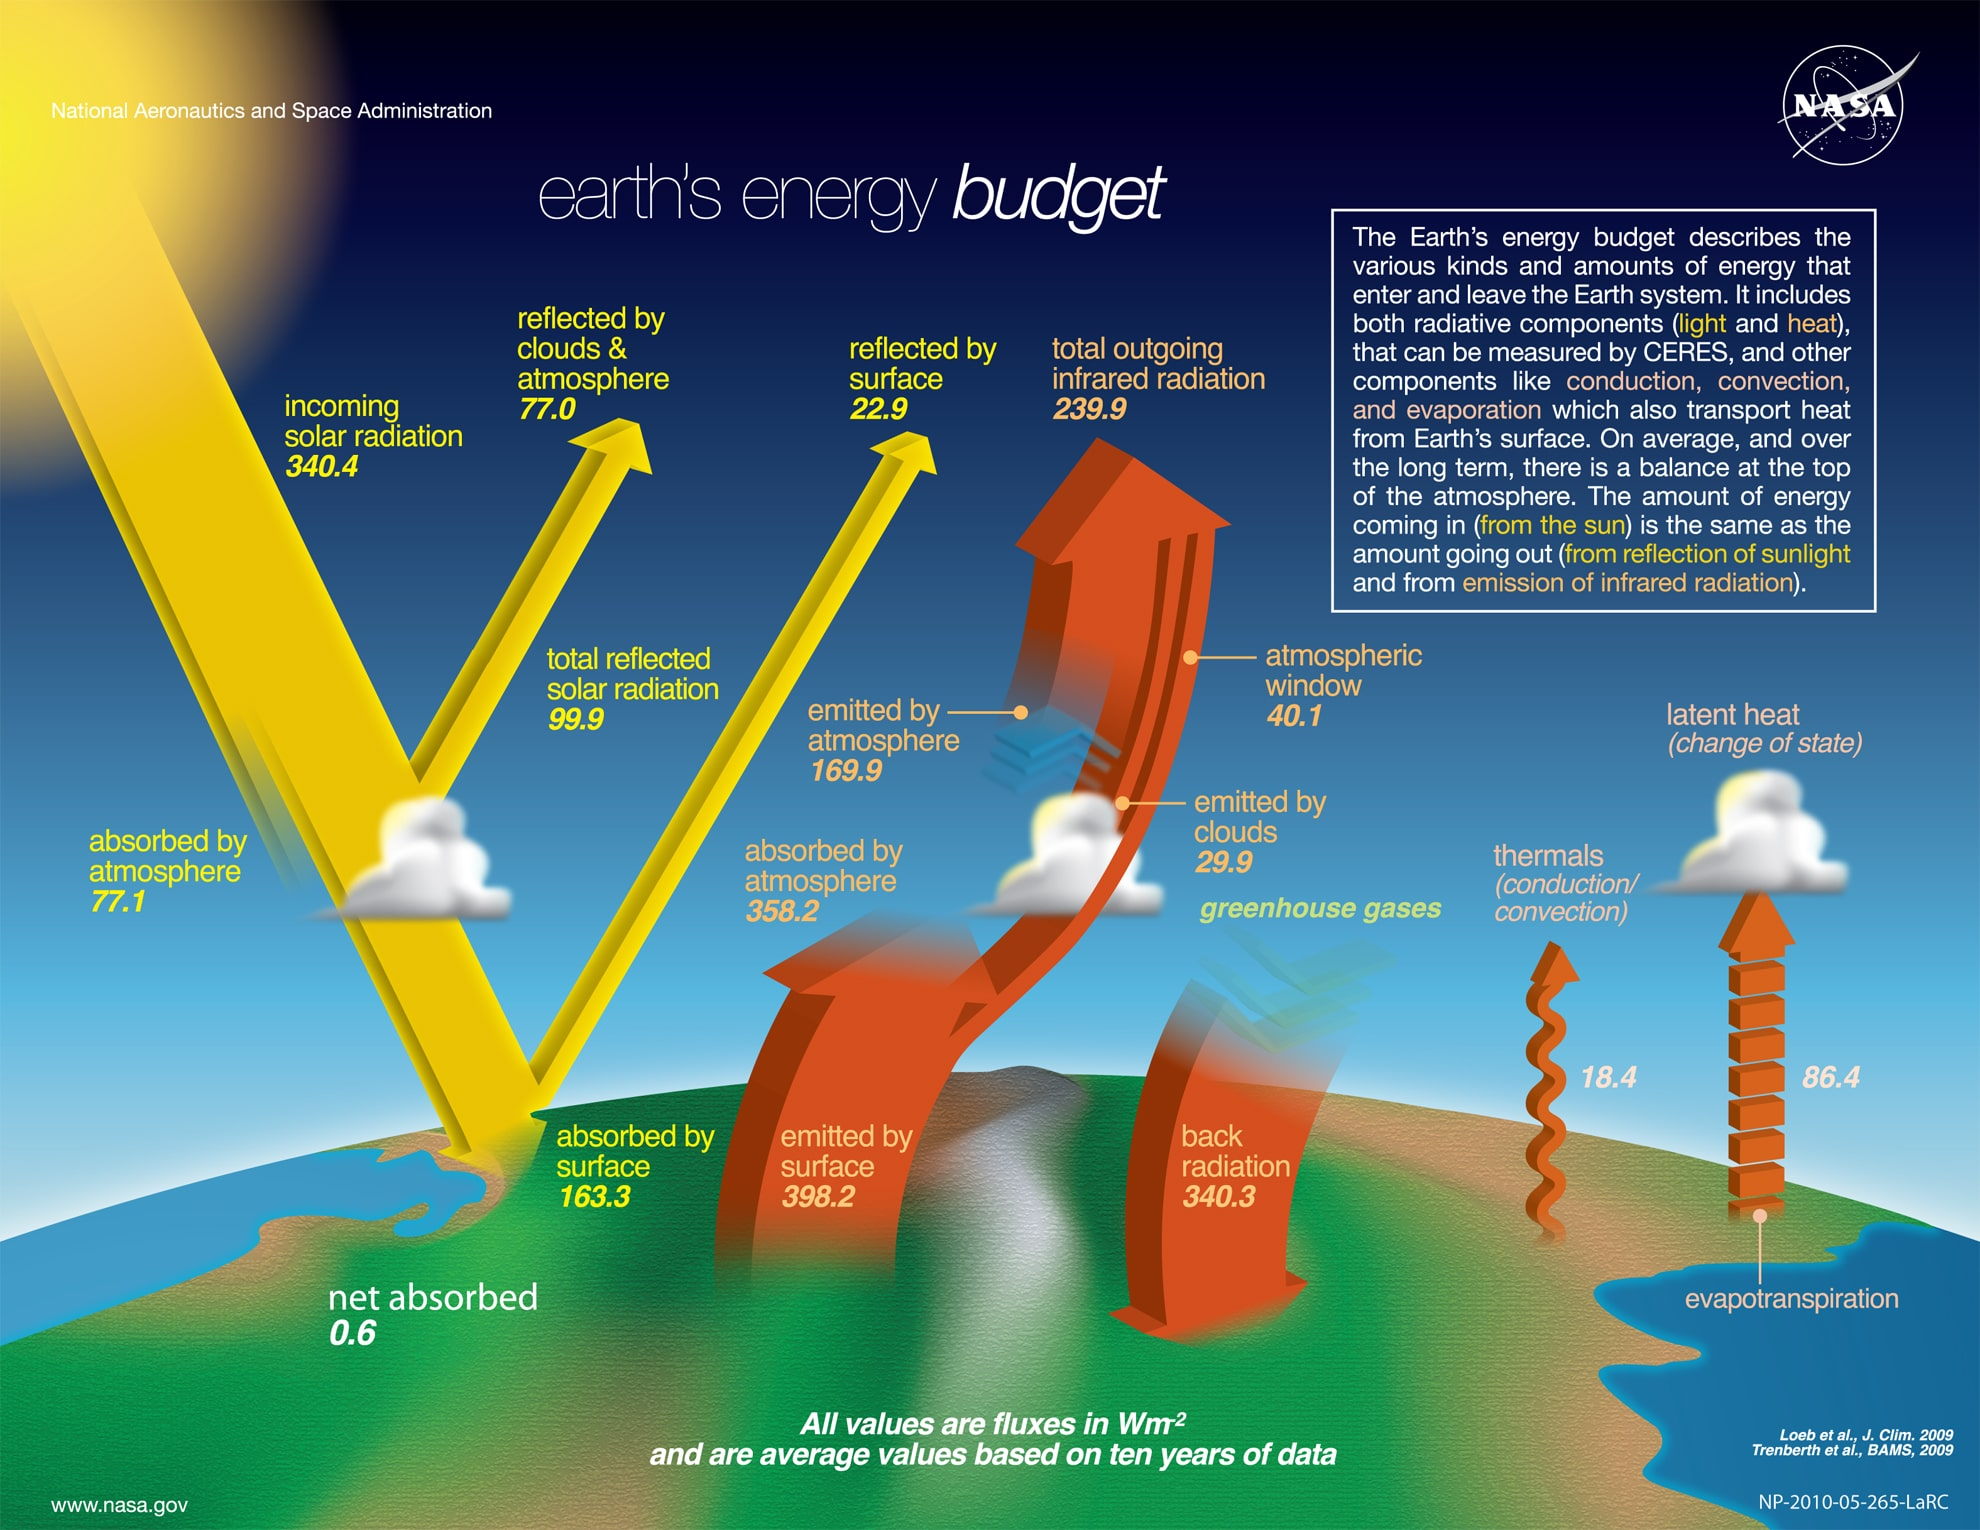

## Part V: Calculating the Meridional (North-South) Heat Transport

We can go beyond a weight factor and calculate the area of each pixel of the dataset, using the formula:

$d\cal{A} = \mathrm{Earth\ Radius}^{2} \times \cos\left(lat\right) \times dlat \times dlon$

where $dlat$ and $dlon$ are the spacing of the points in latitude and longitude (in units radians).

In [ ]:
Earth_Radius = 6.371e6 # Approximate Earth radius in meters

**Q10) Calculate the pixel area using the formula above and create a 2D (`lon`, `lat`) `DataArray` for it**

Hint 1: Check out the [Datasets subsection](#Datasets)

Hint 2: `Xarray`’s [`ones_like` function](https://xarray.pydata.org/en/stable/generated/xarray.ones_like.html) can help you easily create and broadcast `DataArrays`. 

Hint 3: Verify that the sum of all the pixels equals the total surface of an Earth-like sphere: $\cal{A} = 4 \pi \times \mathrm{Earth\ Radius}^{2}$

In [ ]:
# Calculate the pixel area

In [ ]:
# Create a 2D dataset with 
# the pixel area as `data_vars`
# (lon,lat) as `coords`

**Q11) Calculate and plot the total amount of net radiative power in each 1-degree latitude band**

Hint: Multiplying the pixel area ($m^{2}$) with the radiative flux ($W m^{−2}$) gives you the total amount of radiative power or simply radiation ($W$) absorbed (or emitted, depending on your sign conventions) in each pixel

In [ ]:
# Calculate the total radiation in each pixel

In [ ]:
# Calculate the total radiation in each 1-degree latitude band

In [ ]:
# Plot the result as a function of latitude,
# and don't forget units in your plots labels 

**Q12) Calculate and plot the cumulative sum of the net radiation with respect to latitude (in units W)**

Hint: Check out [`Xarray`’s cumsum function](https://xarray.pydata.org/en/stable/generated/xarray.DataArray.cumsum.html).



In [ ]:
# Calculate the cumulative sum of
# the radiative power in each 1-degree latitude band
# with respect to latitude

In [ ]:
# Plot it as a function of latitude

This curve tells you how much energy must be transported meridionally by the ocean and atmosphere in order to account for the radiative imbalance at the top of the atmosphere. You should get a curve like this:

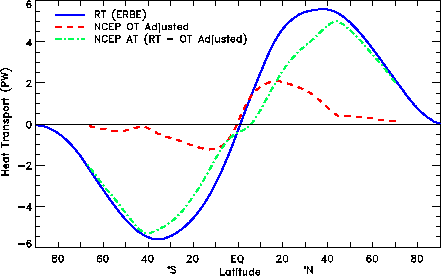

Caption: The required total heat transport from the TOA radiation (RT) is compared with the derived estimate of the adjusted ocean heat transport (OT, dashed) and implied atmospheric transport (AT) from NCEP/NCAR reanalyses in PW.

Source: [Trenberth, Kevin E., and Julie M. Caron. "Estimates of meridional atmosphere and ocean heat transports." *Journal of Climate* 14.16 (2001): 3433-3443.](https://journals.ametsoc.org/view/journals/clim/14/16/1520-0442_2001_014_3433_eomaao_2.0.co_2.xml)

## Part VI: Selecting and Merging Data

For the next problem, use the following approximate locations of four different cities:

| City              | Longitude   | Latitude    |
| ----------------- | ----------- | ----------- |
| Lausanne          | 7E          | 47N         |
| Nome, Alaska      | 165W        | 64N         |
| Colombo, Sri Lanka| 80E         | 7N          |
| Hobart, Tasmania  | 147E        | 43S         |

**Q13) From the global dataset, create a `Dataset` for each point**

Hint: Check out the [Datasets subsection](#Datasets)

In [ ]:
# Create one dataset per city

**Q14) Merge these four datasets into a new dataset with the new dimension `city`**

Hint: Check out the [Concat and Merge subsection](#Concat_Merge)

In [ ]:
# As you merge the datasets, 
# create a new dimension coordinate to hold city names

In [ ]:
# Display the merged dataset

**Q15) Plot the incoming solar radiation and the net radiation at each city**

Hint: Use the built-in [`xarray` plot function](https://xarray.pydata.org/en/stable/generated/xarray.DataArray.plot.html) to have your legend automatically created from the merged dataset.

In [ ]:
# Plot the incoming solar radiation at each city

In [ ]:
# Plot the net radiation at each city